# Analysis

## Prefilter folders

In [71]:
import os, re
import ipywidgets as widgets
from main.FolderInfos import FolderInfos
from main.src.models.ModelFactory import ModelFactory

FolderInfos.init(test_without_data=True)
list_dataout_folders = os.listdir(FolderInfos.data_folder)
list_folders = []
for f in list_dataout_folders:
    full_path = FolderInfos.data_folder+f
    files = os.listdir(full_path)
    files_to_contain = [[re.compile(r".+_parameters.json$"),False]]
    for file in files:
        for i,check in enumerate(files_to_contain):
            if check[0].match(file):
                files_to_contain[i][1] = True
        if len(list(filter(lambda x:x[1] is False,files_to_contain))) == 0: # If all of the required files are in the folder
            list_folders.append(f)
            break

import ipywidgets as widgets
l = []
for f in list_folders:
    wordwidth = max(len(f) * 12, 40)
    wordwidth = str(wordwidth) + 'px'
    l.append(widgets.ToggleButton(
        value=True,
        description=f,
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='',
        icon='check',
        layout = widgets.Layout(width = wordwidth, margin='0px 0px 0px 0px')
    ))
box = widgets.HBox(layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'),width='100%')
box.overflow_x = 'auto'
box.children = l

selected_folder = list_folders
import json
global_initial_dict: dict
def actualize_folders(v):
    global global_initial_dict
    global_initial_dict = {}
    for w in l:
        if w.value is True:
            f = w.description
            full_path = FolderInfos.data_folder+f+FolderInfos.separator
            with open(f"{full_path}{f}parameters.json") as fp:
                global_initial_dict[f] = json.load(fp)
actualize_folders(None)
for w in l:
    w.observe(actualize_folders)
box

## Filter by parameters

In [83]:
from ipywidgets import Dropdown
with open("./extract_data.json","r") as fp:
    dico_access = json.load(fp)
metedata = {}
ipython_widgets = []
changing_widgets = {}
for metedata_name,metadata_dico in dico_access["metadata"].items():
    setpossibilities = set({})
    possibilities_widgets = []
    for f,dico in global_initial_dict.items():
        try:
            value = eval(metadata_dico["access"])(dico)
        except:
            value = metadata_dico["default"]
        if isinstance(value,dict):
            continue
        metedata[f] = value
        if metedata[f] in setpossibilities:
            continue
        setpossibilities.add(metedata[f])
        text_length = max(len(str(value))*12,60)+10
        possibilities_widgets.append(widgets.ToggleButton(
            value=True,
            description=str(value),
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='',
            icon='check',
            layout = widgets.Layout(width = f"{text_length}px", margin='0px 0px 0px 0px')
        ))
    possibilities = list(setpossibilities)
    if len(possibilities) == 0:
        continue
    box = widgets.HBox(layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'),width='100%')
    box.overflow_x = 'auto'
    box.children = [widgets.Label(metedata_name)] + possibilities_widgets
    ipython_widgets.append(box)
    changing_widgets[metedata_name] = possibilities_widgets

box = widgets.VBox(width='100%')
box.children = ipython_widgets

import copy
global_dict = copy.deepcopy(global_initial_dict)
def filter_by_metadata(v):
    dico = {}
    exclude = []
    for name,widgets_vals in changing_widgets.items():
        for w in widgets_vals:
            if w.value is False:
                for f,dico_vals in global_initial_dict.items():
                    try:
                        value = eval(dico_access["metadata"][name]["access"])(dico_vals)
                    except:
                        value = dico_access["metadata"][name]["default"]
                    if value == w.description:
                        exclude.append(f)
    for f in global_initial_dict:
        if f not in exclude:
            dico[f] = global_initial_dict[f]
    global global_dict
    global_dict = dico

for name,widgets_ipy in changing_widgets.items():
    for w in widgets_ipy:
        w.observe(filter_by_metadata)

box

In [84]:
from IPython.display import display
from ipywidgets import Checkbox, VBox, IntSlider, HBox, IntText, FloatText
import plotly.graph_objects as go
import pandas as pd
import main.src.analysis.tools as tls

def loss_access(x,mode):
    return x["training"][f"{mode}_loss"]
def metrics_access(x,name,mode):
    return x["metrics"]["attr_list_metrics"][name][f"{mode}_values"]

dico_loss = {"tr_loss":lambda x:loss_access(x,mode="tr"),"valid_loss":lambda x:loss_access(x,mode="valid")}

dico_accuracy = {"tr_accuracy_classification-0.1":lambda x:metrics_access(x,"accuracy_classification-0.1","tr"),
                 "valid_accuracy_classification-0.1":lambda x:metrics_access(x,"accuracy_classification-0.1","valid"),
                 "tr_accuracy_classification-0.25":lambda x:metrics_access(x,"accuracy_classification-0.25","tr"),
                 "valid_accuracy_classification-0.25":lambda x:metrics_access(x,"accuracy_classification-0.25","valid"),
                 }
dico_mae = {"tr_mae":lambda x:metrics_access(x,"mae","tr"),
            "valid_mae":lambda x:metrics_access(x,"mae","valid")
            }
list_access_functions = {**dico_loss,
                         **dico_accuracy,
                         **dico_mae
                         }
list_values_names_availables = []
for name,f in list_access_functions.items():
    try:
        for dico in global_dict.values():
            f(dico)
        list_values_names_availables.append(name)
    except Exception():
        pass
filters = None
log_scale = None
box = None
from IPython.display import display,clear_output
def actualize(v):
    import numpy as np
    global box
    clear_output()
    list_values_names_availables_filtered = []
    if filters is not None:
        for metric,widg in filters.items():
            if widg.value is True:
                list_values_names_availables_filtered.append(metric)
    list_values_names_availables = list_values_names_availables_filtered
    liste_values = []
    min_val,max_val = 1000000,-1000000
    max_length = 0
    for metric_name in list_values_names_availables:
        for f in global_dict.keys():
            batch_size = global_dict[f]["data"]["batch_size"] * global_dict[f]["data"]["eval_step"] if "valid" in metric_name else global_dict[f]["data"]["batch_size"]
            window = int(window_mean.value/batch_size)
            v = tls.moving_mean(list_access_functions[metric_name](global_dict[f]),window=window)
            x = np.arange(0,len(v)) * batch_size

            max_length = max(np.max(x),max_length)
            min_val = min(min_val,np.min(v[5:]))
            max_val = max(max_val,np.max(v[5:]))
            x = pd.Series(x)
            v = pd.Series(v)
            graph = go.Scatter(x=x,y=v,mode='lines',name=f"{metric_name} {f}",hovertemplate='Sample n°: %{x}'+f'<br>{metric_name}:'+' %{y}')
            liste_values.append(graph)
    # print(min_val,max_val)



    fig = go.Figure(
        data=liste_values,
        layout=go.Layout(
            title=go.layout.Title(text=""),
            xaxis_title="Number of samples processed",
            yaxis_title=f"Values",
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            yaxis={'tickformat':'.1e',

                   },


        )
    )
    if log_scale is not None and log_scale.value is True:
        fig.update_yaxes(type="log")
    fig.show()
    if box is not None:
        display(box)
    return min_val,max_val

window_mean = IntText(
    value=100,
    description='Mean window:',
    disabled=False
)
mini,maxi = actualize(None)
clear_output()
log_scale = widgets.ToggleButton(False,description="y_log")
filters = {name:widgets.ToggleButton(False,description=name) for name in list_values_names_availables}
list_widgets = [*filters.values(),log_scale,window_mean]
box1 = VBox(list(filters.values()))
box = HBox([box1,VBox([log_scale,window_mean])])







for w in list_widgets:
    w.observe(actualize)
box

In [3]:
from ipywidgets import Dropdown

choice_folder = Dropdown(
    options=selected_folder,
    value=selected_folder[0],
    description='Folder to vizualize result',
    disabled=False,
         )
display(choice_folder)

Dropdown(description='Folder to vizualize result', options=('2021-06-10_11h31min34s_', '2021-06-11_12h30min51s…

Output()

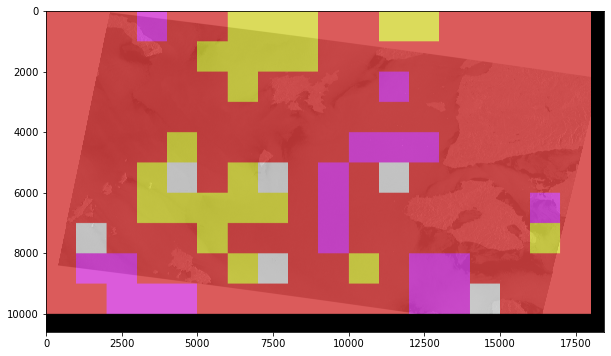

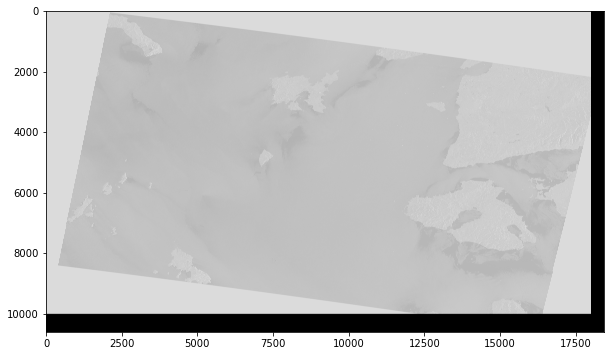

In [4]:
choice_folder = choice_folder.value
from main.src.models.ModelFactory import ModelFactory
from main.src.analysis.tools import RGB_Overlay_Patch
import json
FolderInfos.init(test_without_data=True)
folder = FolderInfos.data_folder + choice_folder + FolderInfos.separator
with open(folder + choice_folder + "parameters.json", "r") as fp:
    dico = json.load(fp)

rgb_overlay = RGB_Overlay_Patch(usage_type="classification", patch_creator="fixed_px",
                            grid_size=dico["data"]["dataset"]["attr_patch_creator"]["attr_grid_size_px"],
                            input_size=dico["data"]["dataset"]["attr_dataset"]["attr_resizer"][
                                "attr_out_size_w"])
epoch = 0
iteration = 6080
import torch
name = "027481_0319CB_0EB7"

device = torch.device("cuda")
model = ModelFactory(model_name=dico["model"]["attr_model_name"], num_classes=dico["model"]["attr_num_classes"])()
model.to(device)
model.load_state_dict(torch.load(f"{folder}{choice_folder}_model_epoch-{epoch}_it-{iteration}.pt"))
array_overlay = rgb_overlay(name_img=name, model=model, blending_factor=0.5, device=device)



import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(array_overlay[0])
plt.savefig(f"{folder}{choice_folder}_{name}_rgb_overlay_true.png")
plt.figure(figsize=(10,10))
plt.imshow(array_overlay[1])
plt.savefig(f"{folder}{choice_folder}_{name}_rgb_overlay_pred.png")
